# 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-03-04 22:05:43.470006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741122343.494928   92087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741122343.503113   92087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 22:05:43.535882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1741122346.276196   92087 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
import tensorflow_datasets as tfds

from keras.api.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from keras.api.models import Sequential, Model
from keras.api.applications.xception import Xception, preprocess_input
# from keras.api.applications.mobilenet import MobileNet, preprocess_input
# from keras.api.applications import MobileNetV3Large, ResNet50
from keras.api.optimizers import SGD, Nadam, Adam
from keras.api.optimizers.schedules import CosineDecayRestarts
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.api import layers
from keras.api.regularizers import l2
import keras

import collections

import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

## Loading data

In [4]:
start_time = datetime.datetime.now()

In [5]:
ds, info = tfds.load(
    "beans",
    split="all",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
)

n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

# Same ratio as in original dataset
train_size = 1034
val_size = 133
test_size = 128

batch_size = 32

In [6]:
ds_pd = tfds.as_dataframe(ds, info)
ds_pd_images = ds_pd["image"]
ds_pd_labels = ds_pd["label"]

2025-03-04 22:05:48.452142: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-04 22:05:49.439764: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Stratified split

Original split caused huge difference in performance of model when doing predictions with validation and test data sets.

In [7]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    ds_pd_images,
    ds_pd_labels,
    train_size=train_size,
    random_state=42,
    shuffle=True,
    stratify=ds_pd_labels,
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    train_size=val_size,
    random_state=42,
    shuffle=True,
    stratify=temp_labels,
)

ds_train = tf.data.Dataset.from_tensor_slices((np.array(train_data.tolist()), np.array(train_labels.tolist())))
ds_valid = tf.data.Dataset.from_tensor_slices((np.array(val_data.tolist()), np.array(val_labels.tolist())))
ds_test = tf.data.Dataset.from_tensor_slices((np.array(test_data.tolist()), np.array(test_labels.tolist())))

2025-03-04 22:05:50.914746: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775500000 exceeds 10% of free system memory.
2025-03-04 22:05:51.726878: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775500000 exceeds 10% of free system memory.


In [8]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test)))

2025-03-04 22:05:52.138871: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775500000 exceeds 10% of free system memory.


1034
133
128


2025-03-04 22:05:52.711504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-04 22:05:52.838762: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

In [10]:
# Make sure that ratio of different classes is same across datasets
print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


## Preprocess and Augmentation

In [11]:
preprocess = Sequential([
    layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    layers.Lambda(preprocess_input)
])

# preprocess_and_augmentation = Sequential([
#     layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(factor=(-0.2, 0.2)),
#     layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#     # layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), 
#     layers.RandomContrast(factor=0.2),
#     layers.RandomBrightness(factor=(-0.2, 0.2)),
#     layers.GaussianNoise(stddev=0.05),
#     layers.Lambda(preprocess_input)
# ])

preprocess_and_augmentation = Sequential([
    layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    layers.RandomFlip(mode="horizontal", seed=42),
    layers.RandomRotation(factor=0.05, seed=42),
    layers.RandomContrast(factor=0.2, seed=42),
    layers.Lambda(preprocess_input)
])

## Input pipeline

In [12]:
ds_train = ds_train.map(
    lambda X, y: (preprocess_and_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [13]:
ds_valid = ds_valid.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [14]:
ds_test = ds_test.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2025-03-04 22:05:53.493476: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775500000 exceeds 10% of free system memory.
2025-03-04 22:05:53.586348: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_7}}
2025-03-04 22:06:01.335476: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of

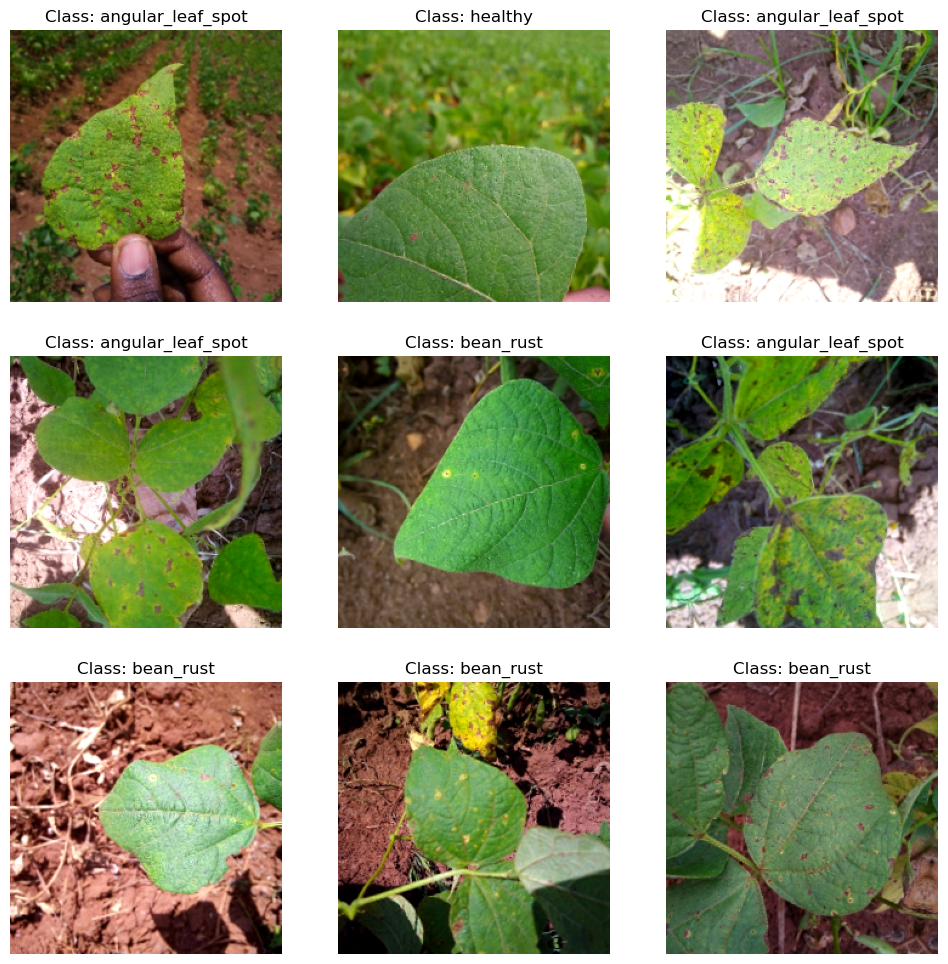

In [15]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    # X_batch = preprocess_and_augmentation(X_batch)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Base model with pre-trained weights

In [16]:
tf.keras.backend.clear_session()

In [17]:
base_model = Xception(
    input_shape=(224, 224, 3), include_top=False
)

In [18]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=outputs)

In [19]:
for layer in base_model.layers:
    layer.trainable = False

## Initial training without touching base model

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode="min")

In [21]:
optimizer = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"], jit_compile=False)
history = model.fit(ds_train, validation_data=ds_valid, epochs=3, callbacks=[early_stopping])

Epoch 1/3


2025-03-04 22:06:04.247242: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 775500000 exceeds 10% of free system memory.
2025-03-04 22:06:04.631839: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_7}}
I0000 00:00:1741122368.621183   92155 cuda_dnn.cc:529] Loaded cuDNN version 90700


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step - accuracy: 0.4959 - loss: 2.2250 - val_accuracy: 0.7218 - val_loss: 1.5388
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 770ms/step - accuracy: 0.7166 - loss: 2.2836 - val_accuracy: 0.6541 - val_loss: 3.4653
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step - accuracy: 0.7362 - loss: 2.6282 - val_accuracy: 0.7970 - val_loss: 1.2799


4/4 - 3s - 725ms/step - accuracy: 0.8438 - loss: 0.7956
0.84375


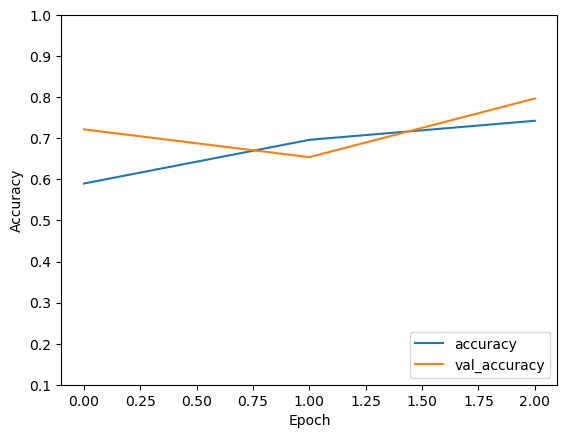

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

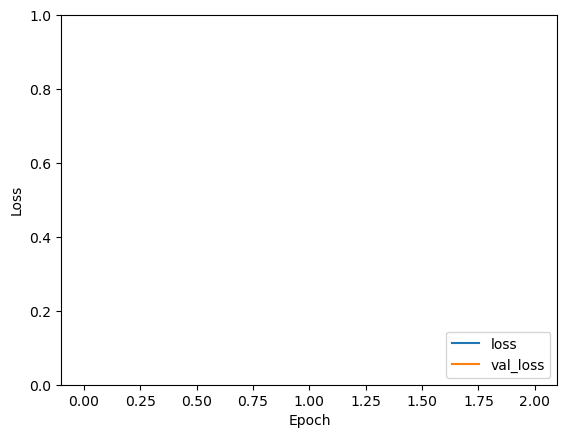

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Fine tuning

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="min")

In [25]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"], jit_compile=False)
history = model.fit(ds_train, validation_data=ds_valid, epochs=10, callbacks=[early_stopping])

Epoch 1/10


33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7007 - loss: 1.1264 - val_accuracy: 0.5113 - val_loss: 3.3204
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9370 - loss: 0.2075 - val_accuracy: 0.7293 - val_loss: 1.5461
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9844 - loss: 0.0517 - val_accuracy: 0.8647 - val_loss: 0.5258
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9997 - loss: 0.0059 - val_accuracy: 0.8571 - val_loss: 0.4914
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9908 - loss: 0.0239 - val_accuracy: 0.8872 - val_loss: 0.4649
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9952 - loss: 0.0105 - val_accuracy: 0.8797 - val_loss: 0.3994
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9098 - val_loss: 0.3729
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9951 - loss: 0.0095 - val_accuracy: 0.8797 - val_loss: 0.6262
Epo

In [26]:
train_loss, train_acc = model.evaluate(ds_train, verbose=2)
print(train_acc)

33/33 - 23s - 682ms/step - accuracy: 1.0000 - loss: 5.1749e-04
1.0


In [27]:
val_loss, val_acc = model.evaluate(ds_valid, verbose=2)
print(val_acc)

5/5 - 3s - 590ms/step - accuracy: 0.9098 - loss: 0.3729
0.9097744226455688


In [28]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

4/4 - 3s - 698ms/step - accuracy: 0.9531 - loss: 0.2387
0.953125


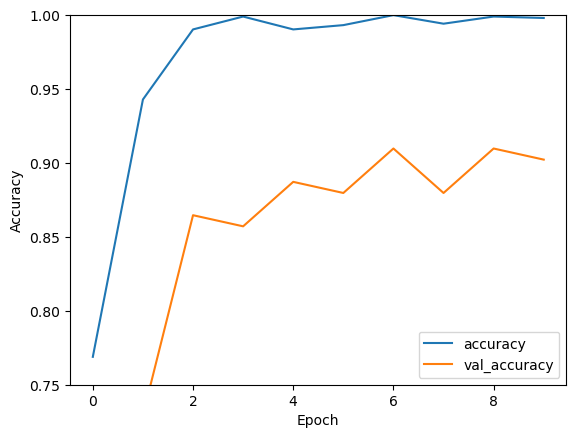

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

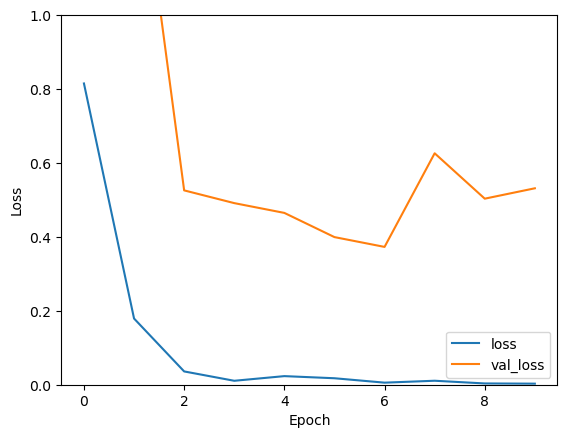

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

- accuracy without data augmentation or dropout: train: 1.00, validation: 0.9323, test: 0.9062
- accuracy with data augmentation but without dropout: train: 1.00, validation: 0.9549, test: 0.9062
- accuracy with data augmentation and dropout (0.25) : train: 0.9993, validation: 0.9549, test: 0.9453 

In [31]:
duration = datetime.datetime.now() - start_time
print(duration)

0:11:57.258113
